### Постановка бизнес-задачи

Проанализировать данные о торговых точках Старбакс в Москве и выделить кластер наименнее эффективных точек. Оценить влияние на выручку, маржинальность и удовлетворенность клиентов закрытия неэффективного кластера

### Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster
import scipy

import folium
import geopy

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("Lesson_5.csv")

In [3]:
df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39


In [4]:
del df["State/Province"]
del df["Postcode"]
del df["Phone Number"]
del df["Store Name"]

In [5]:
df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39


In [6]:
df["Store Number"].value_counts().sort_values(ascending=False)[:10]

19773-160973    2
28809-251348    1
22126-218024    1
17127-178586    1
17688-182164    1
18182-182165    1
23359-229184    1
30781-99022     1
20423-205465    1
20424-205466    1
Name: Store Number, dtype: int64

In [7]:
df.loc[df['Store Number'] == "19773-160973"]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
8028,Starbucks,19773-160973,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,NaN,NaN
8159,Starbucks,19773-160973,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,126.92,37.53


In [8]:
np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0]

array([8028], dtype=int64)

In [9]:
# 1 способ
# df = df.drop(df[(df['Store Number'] == "19773-160973") & (df['Longitude']).isna()].index.to_list())

In [10]:
# 2 способ
df = df.drop(np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0])

In [12]:
df["Store Number"].value_counts().sort_values(ascending=False)[:10]

47370-257954    1
3178-141407     1
47089-256771    1
22126-218024    1
17127-178586    1
17688-182164    1
18182-182165    1
23359-229184    1
30781-99022     1
20423-205465    1
Name: Store Number, dtype: int64

In [13]:
df.set_index(df["Store Number"], inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25599 entries, 47370-257954 to 47609-253286
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           25599 non-null  object 
 1   Store Number    25599 non-null  object 
 2   Ownership Type  25599 non-null  object 
 3   Street Address  25597 non-null  object 
 4   City            25584 non-null  object 
 5   Country         25599 non-null  object 
 6   Timezone        25599 non-null  object 
 7   Longitude       25599 non-null  float64
 8   Latitude        25599 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.0+ MB


In [15]:
df.duplicated().value_counts()

False    25599
dtype: int64

In [16]:
df.loc[pd.isna(df['Street Address']) == True]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,
30997-103902,Starbucks,30997-103902,Joint Venture,NaN,부산,KR,GMT+09:00 Asia/Seoul,129.15,35.16
1329-152826,Starbucks,1329-152826,Joint Venture,NaN,광주,KR,GMT+09:00 Asia/Seoul,126.91,35.15


In [17]:
df.loc[pd.isna(df['City']) == True]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,
31657-104436,Starbucks,31657-104436,Licensed,طريق الكورنيش أبراج سان ستيفانو,NaN,EG,GMT+2:00 Africa/Cairo,29.96,31.24
32152-109504,Starbucks,32152-109504,Licensed,كورنيش النيل أبراج النايل سيتى,NaN,EG,GMT+2:00 Africa/Cairo,31.23,30.07
32314-115172,Starbucks,32314-115172,Licensed,"الكيلو 28 طريق الاسكندرية الصحراوى, سيتى سنتر ...",NaN,EG,GMT+2:00 Africa/Cairo,31.03,30.06
31479-105246,Starbucks,31479-105246,Licensed,"شارع مكرم عبيد, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.09
31756-107161,Starbucks,31756-107161,Licensed,"شارع عمر بن الخطاب, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
1397-139244,Starbucks,1397-139244,Licensed,"شارع عمر بن الخطاب, كارفور المعادى",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
32191-116645,Starbucks,32191-116645,Licensed,القطامية الطريق الدائرى,NaN,EG,GMT+2:00 Africa/Cairo,31.30,29.99
3664-142484,Starbucks,3664-142484,Licensed,"34شارع سليمان أباظة المهندسين, تيفولى مول",NaN,EG,GMT+2:00 Africa/Cairo,31.20,30.06
3562-131562,Starbucks,3562-131562,Licensed,"ألماظة ميدان الجوهر شارع أحمد فوزى, صالة السفر 1",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.08


In [18]:
df.fillna("No_data", inplace = True)

### EDA

In [19]:
!pip install sweetviz

In [20]:
import sweetviz as sv

In [21]:
feature_config = sv.FeatureConfig(skip=["Store Number", "Street Address" ])


In [22]:
report = sv.analyze(df, feat_cfg = feature_config)

report.show_html('Lesson_5_report.html')

                                             |     | [  0%]   00:00 -> (? left)

Report Lesson_5_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Добавление показателей эффективности кофеен

In [23]:
df["Revenue"] = np.random.randint(low=150000, high=250000, size=len(df))
df["Cost"] = np.random.randint(low=120000, high=210000, size=len(df))
df["Satisfaction"] = np.random.choice(["Very_satisfied", "Satisfied", "Neither", "Dissatisfied", "Very dissatisfied"], size=len(df), p=[0.4,0.4,0.1,0.07, 0.03])

In [24]:
df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
47370-257954,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51,219917,191852,Satisfied
22331-212325,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42,203266,207513,Very_satisfied
47089-256771,Starbucks,47089-256771,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39,184592,150951,Satisfied


In [25]:
city = "Moscow"

locator = geopy.geocoders.Nominatim(user_agent="Lesson_5")
location = locator.geocode(city)
location = [location.latitude, location.longitude]

In [26]:
Moscow_df = df.loc[df['City'] == "Moscow"]

In [27]:
Moscow_df["Country"].value_counts()

RU    74
US     3
Name: Country, dtype: int64

In [28]:
Moscow_df.loc[Moscow_df['Country'] == "US"]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
79663-115245,Starbucks,79663-115245,Licensed,1320 Blaine St,Moscow,US,GMT-08:00 America/Los_Angeles,-116.98,46.72,194512,147476,Satisfied
3760-126584,Starbucks,3760-126584,Licensed,710 S Deakin St,Moscow,US,GMT-08:00 America/Los_Angeles,-117.01,46.73,215336,195995,Very_satisfied
3357-166484,Starbucks,3357-166484,Company Owned,1930 West Pullman Road,Moscow,US,GMT-08:00 America/Los_Angeles,-117.03,46.73,177952,154430,Satisfied


In [29]:
Moscow_df = Moscow_df.loc[df['Country'] == "RU"]

In [30]:
Moscow_map = folium.Map(location=location, zoom_start=10)

In [31]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Moscow_df["size"] = scaler.fit_transform(Moscow_df["Revenue"].values.reshape(-1,1)).reshape(-1)

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    
    if row["Revenue"] < row["Cost"]:
        current_color = "red"
    else:
        current_color = "green"
        
    
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(Moscow_map)

In [32]:
Moscow_map

In [33]:
Moscow_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size
Store Number,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,198896,163955,Very_satisfied,8.726649
1562-152965,Starbucks,1562-152965,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,218604,176579,Very_satisfied,11.163195
3011-138431,Starbucks,3011-138431,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,169068,176288,Dissatisfied,5.038944


### Кластеризация

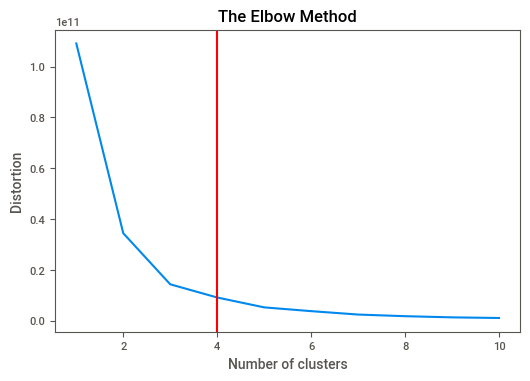

In [34]:
Moscow_df['Profit'] = Moscow_df['Revenue'] - Moscow_df['Cost']
Moscow_df['Satisfaction'] = Moscow_df['Satisfaction'].map({"Very_satisfied": 10, "Satisfied":6, "Neither" : 4, "Dissatisfied": 2, "Very dissatisfied": 1})

X = Moscow_df[["Satisfaction","Profit"]]
max_k = 10


distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_)
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))


fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

In [35]:
distortions

[109097197985.21616,
 34470794807.2228,
 14386075239.754463,
 9194786542.000076,
 5312437419.164024,
 3826259851.018282,
 2490546122.0103893,
 1840742759.4229772,
 1386019825.034629,
 1134476522.826296]

In [36]:
np.diff(distortions, 2)

array([5.45416836e+10, 1.48934309e+10, 1.30893957e+09, 2.39617155e+09,
       1.50463839e+08, 6.85910366e+08, 1.95080428e+08, 2.03179632e+08])

In [37]:
p = np.array([2, 5, 55, 44, 9])
np.diff(p, 2)

array([ 47, -61, -24])

In [38]:
[i*100 for i in np.diff(distortions, 2)]

[5454168361052.501,
 1489343086971.395,
 130893957491.8335,
 239617155469.03094,
 15046383913.78498,
 68591036642.04805,
 19508042819.906403,
 20317963218.00151]

In [39]:
[i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))

4

In [40]:
k = 7
model = KMeans(n_clusters=k)

X = Moscow_df[["Satisfaction","Profit"]]
Moscow_df["cluster"] = model.fit_predict(X)

In [41]:
Moscow_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size,Profit,cluster
Store Number,,,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,198896,163955,10,8.726649,34941,2
1562-152965,Starbucks,1562-152965,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,218604,176579,10,11.163195,42025,2
3011-138431,Starbucks,3011-138431,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,169068,176288,2,5.038944,-7220,0


In [42]:
new_moscow_map = folium.Map(location=location, zoom_start=10)

In [43]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Moscow_df["size"] = scaler.fit_transform(Moscow_df["Revenue"].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5:"black", 6:"grey"}

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(new_moscow_map)

In [44]:
new_moscow_map

In [45]:
columns = ["Cluster", "Average_Revenue", "Sum_Revenue", "Average_Profit", "Sum_Profit", "Average_Satisfaction"]
result_df = pd.DataFrame(columns = columns)
for i in set(Moscow_df['cluster']):
    cluster_df = Moscow_df.loc[Moscow_df['cluster'] == i]
    result_df.loc[i] = [i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]
 

In [46]:
result_df

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit,Average_Satisfaction
0,0.0,182369.428571,1276586.0,-5744.285714,-40210.0,6.285714
1,1.0,225910.818182,2485019.0,87121.272727,958334.0,7.636364
2,2.0,201652.818182,4436362.0,38134.909091,838968.0,7.000000
3,3.0,182479.363636,2007273.0,13893.454545,152828.0,6.000000
4,4.0,235339.000000,1647373.0,105760.428571,740323.0,6.142857
5,5.0,227552.545455,2503078.0,64086.272727,704949.0,7.454545
6,6.0,165018.200000,825091.0,-29480.600000,-147403.0,6.400000


In [47]:
Moscow_df.groupby('cluster', as_index=False).agg({'Revenue': ['mean', 'sum'], 'Profit':['mean', 'sum']}).columns

MultiIndex([('cluster',     ''),
            ('Revenue', 'mean'),
            ('Revenue',  'sum'),
            ( 'Profit', 'mean'),
            ( 'Profit',  'sum')],
           )

In [48]:
# 2 способ
pd.DataFrame(Moscow_df.groupby('cluster', as_index=False)\
             .agg({'Revenue': ['mean', 'sum'], 'Profit':['mean', 'sum']})\
             .to_numpy(),\
             columns=['Cluster','Average_Revenue','Sum_Revenue','Average_Profit','Sum_Profit'])

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit
0,0.0,182369.428571,1276586.0,-5744.285714,-40210.0
1,1.0,225910.818182,2485019.0,87121.272727,958334.0
2,2.0,201652.818182,4436362.0,38134.909091,838968.0
3,3.0,182479.363636,2007273.0,13893.454545,152828.0
4,4.0,235339.000000,1647373.0,105760.428571,740323.0
5,5.0,227552.545455,2503078.0,64086.272727,704949.0
6,6.0,165018.200000,825091.0,-29480.600000,-147403.0


In [49]:
# 3 способ
Moscow_df.groupby('cluster', as_index=False).agg({'Revenue': ['mean', 'sum'], 'Profit':['mean', 'sum']})

cluster        Revenue                  Profit        
                    mean      sum           mean     sum
0       0  182369.428571  1276586   -5744.285714  -40210
1       1  225910.818182  2485019   87121.272727  958334
2       2  201652.818182  4436362   38134.909091  838968
3       3  182479.363636  2007273   13893.454545  152828
4       4  235339.000000  1647373  105760.428571  740323
5       5  227552.545455  2503078   64086.272727  704949
6       6  165018.200000   825091  -29480.600000 -147403

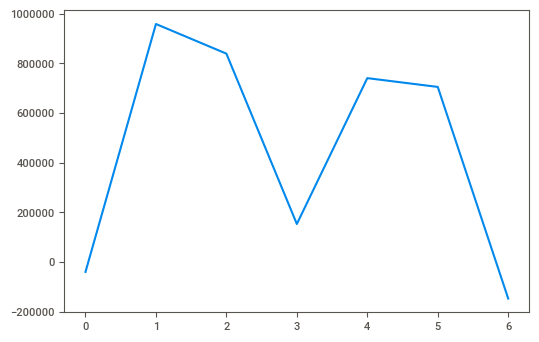

In [50]:
plt.plot(result_df["Cluster"], result_df["Sum_Profit"])

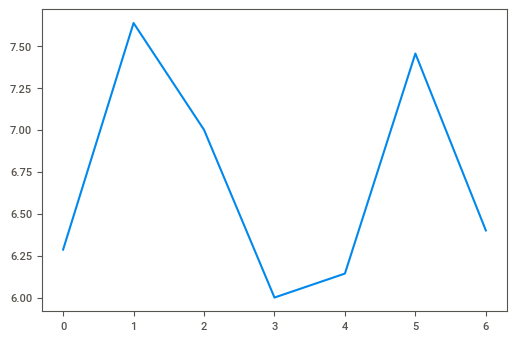

In [51]:
plt.plot(result_df["Cluster"], result_df["Average_Satisfaction"])

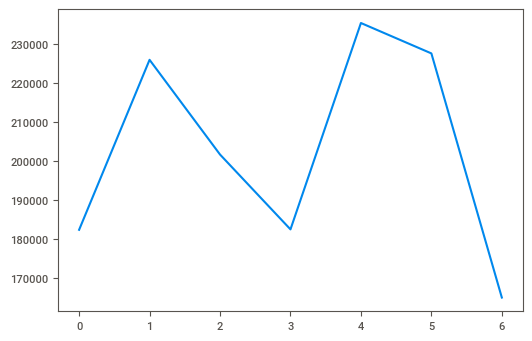

In [52]:
plt.plot(result_df["Cluster"], result_df["Average_Revenue"])

### Итоговое сравнение

#### До оптимизации

In [53]:
print("Выручка сети: %.2f  " % Moscow_df["Revenue"].sum())
print("Прибыль сети: %.2f " % Moscow_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % Moscow_df["Satisfaction"].mean())

Выручка сети: 15180782.00  
Прибыль сети: 3207789.00 
Средняя удовлетворенность клиента: 6.82 


#### После оптимизации

In [54]:
after_optimisation_df = Moscow_df.loc[Moscow_df["cluster"] != 4]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 13533409.00 
Прибыль сети: 2467466.00 
Средняя удовлетворенность клиента: 6.90 


### Самостоятельный кейс №5

Измените модель таким образом, чтобы построить кластеры для оптимизации сети по всей России.

In [55]:
Russia_df = df.loc[df['Country'] == "RU"]

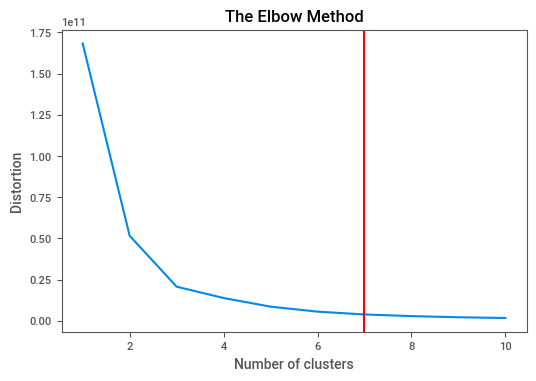

In [56]:
Russia_df['Profit'] = Russia_df['Revenue'] - Russia_df['Cost']
Russia_df['Satisfaction'] = Russia_df['Satisfaction'].map({"Very_satisfied": 10, "Satisfied":6, "Neither" : 4, "Dissatisfied": 2, "Very dissatisfied": 1})

X = Russia_df[["Satisfaction","Profit"]]
max_k = 10


distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_)
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))


fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

In [57]:
k = 7
model = KMeans(n_clusters=k)

X = Russia_df[["Satisfaction","Profit"]]
Russia_df["cluster"] = model.fit_predict(X)

In [58]:
new_map = folium.Map(location=location, zoom_start=2)

In [59]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Russia_df["size"] = scaler.fit_transform(Russia_df["Revenue"].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5:"black", 6:"grey"}

for index, row in Russia_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(new_map)

In [60]:
new_map

In [61]:
columns = ["Cluster", "Average_Revenue", "Sum_Revenue", "Average_Profit", "Sum_Profit", "Average_Satisfaction"]
result_df = pd.DataFrame(columns = columns)
for i in set(Russia_df['cluster']):
    cluster_df = Russia_df.loc[Russia_df['cluster'] == i]
    result_df.loc[i] = [i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]
 

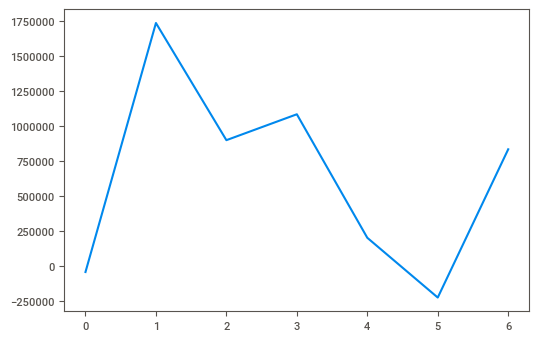

In [62]:
plt.plot(result_df["Cluster"], result_df["Sum_Profit"])

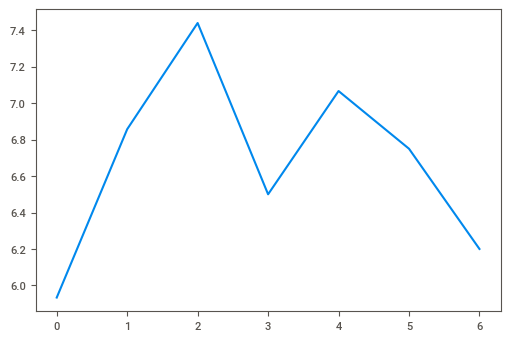

In [63]:
plt.plot(result_df["Cluster"], result_df["Average_Satisfaction"])

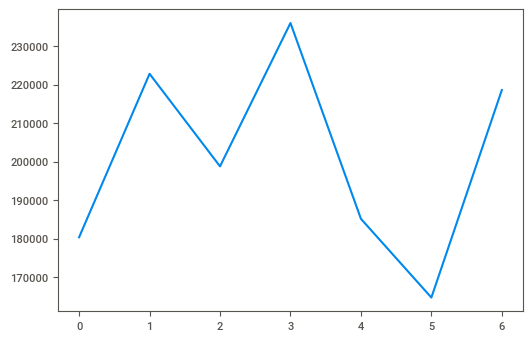

In [64]:
plt.plot(result_df["Cluster"], result_df["Average_Revenue"])

#### До оптимизации

In [65]:
print("Выручка сети: %.2f  " % Russia_df["Revenue"].sum())
print("Прибыль сети: %.2f " % Russia_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % Russia_df["Satisfaction"].mean())

Выручка сети: 22086265.00  
Прибыль сети: 4477443.00 
Средняя удовлетворенность клиента: 6.76 


#### После оптимизации

In [66]:
after_optimisation_df = Russia_df.loc[Russia_df["cluster"] != 2]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 17117248.00 
Прибыль сети: 3579619.00 
Средняя удовлетворенность клиента: 6.56 


In [67]:
after_optimisation_df = Russia_df.loc[Russia_df["cluster"] != 0]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 19381030.00 
Прибыль сети: 4521783.00 
Средняя удовлетворенность клиента: 6.89 


Правовая оговорка. Товарный знак Старбакс, упоминающийся в данном уроке, защищен как объект авторского права. Товарный знак Старбакс принадлежит Старбакс и/или его филиалам и аффилированным лицам или иным лицам, которые передали право на свои материалы Старбакс. Информация о расположении кофеен является публично доступной и не является коммерческой тайной Старбакс и/или его филиалов и аффилированных лиц или иных лиц, которые связаны с Старбакс. Информация о посещаемости кофеен, эффективности точек, количестве сотрудников и других производных показателях бизнеса является случайно сгенерированной (вымышленной) и не может быть использована для проведения анализа деятельности и/или быть основой для принятия каких либо решений, в том числе об открытии и/или закрытии позиций на фондовых и срочных рынках в любых странах. Старбакс в России - ООО «Кофе Сирена» 125040, г. Москва, ул. Правды, дом 26 ОГРН 5077746299560 ИНН 7714685546